### Solving a Stokes equation on domains with different obstacles
We are give a domain $\Omega_\chi \subset \R^2$ which is defined as all points $x \in (0, 1)^2$ such that $\chi(x) = 1$. We will only consider randomly placed circles cut out from the domain $(0, 1)^2$. Our goal is to solve the following Stokes
equation on $\Omega_\chi$:
\begin{align*}
    -\mu \Delta u - \nabla p &= 0 &&\text{ in } \Omega_\chi, \\
    \nabla \cdot u &= 0 &&\text{ in } \Omega_\chi.
\end{align*}
With the boundary conditions:
\begin{align*}
    u &= u_{in} &&\text{ when } x_1 = 0, \\
    (\mu \nabla u + p) \cdot n &= 0 &&\text{ when } x_1 = 1, \\
    u &= 0 &&\text{ everywhere else on } \partial \Omega_\chi.
\end{align*}
Here, $u_{in}$ is a given inflow profile.

Our goal is to learn the solution operator that maps the domain $\Omega_\chi$ to the solution $u$.

In [ ]:
import os, sys
sys.path.append(os.getcwd())

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [14]:
save_path = "/localdata/tomfre/FNO_data_Stokes"
input_data = torch.tensor(np.load(f"{save_path}/stokes_input.npy"), dtype=torch.float32)
output_data = torch.tensor(np.load(f"{save_path}/stokes_output.npy"), dtype=torch.float32)

print("Available data points:", len(input_data))
print("Shape of data:", input_data.shape)

Available data points: 20000
Shape of data: torch.Size([20000, 64, 64, 1])


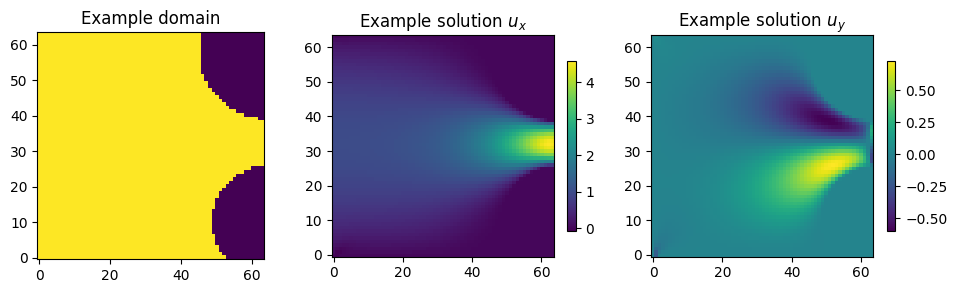

In [15]:
# Plot one example of the data
plot_idx = 0

f, axarr = plt.subplots(1, 3, figsize=(10, 3))
axarr[0].imshow(input_data[plot_idx, :, :, 0], origin='lower')
axarr[0].title.set_text(r"Example domain")
img = axarr[1].imshow(output_data[plot_idx, :, :, 0], origin='lower')
plt.colorbar(img, ax=axarr[1], shrink=0.75)
axarr[1].title.set_text(r"Example solution $u_x$")
img = axarr[2].imshow(output_data[plot_idx, :, :, 1], origin='lower')
axarr[2].title.set_text(r"Example solution $u_y$")
plt.colorbar(img, ax=axarr[2], shrink=0.75)
plt.tight_layout()

In [16]:
X = tp.spaces.R2("x")
Chi = tp.spaces.R1("chi")
U = tp.spaces.R2("u")

fn_space_chi = tp.spaces.FunctionSpace(X, Chi)
fn_space_U = tp.spaces.FunctionSpace(X, U)

In [17]:
# Split data into training and testing:
total_data = len(input_data)
train_N = int(0.9*total_data)

train_in = input_data[:train_N]
train_out = output_data[:train_N]

test_in = input_data[train_N:]
test_out = output_data[train_N:]

# Define FunctionSet (DataSet)
data_functionset_input = tp.domains.DataFunctionSet(fn_space_chi, train_in)
data_functionset_output = tp.domains.DataFunctionSet(fn_space_U, train_out)

In [18]:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(2000, data_functionset_input)
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

In [19]:
## FNO
hidden_channels = 16

model = tp.models.FNO(Chi, U, 
                      fourier_layers=3, 
                      hidden_channels=hidden_channels, 
                      fourier_modes=(8, 8), # Here two modes need to be set (one for each space direction) 
                      skip_connections=True)

In [20]:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                                 input_function_sampler=functionsampler_input, 
                                                 output_function_sampler=functionsampler_output)

In [21]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 2000, "gamma":0.2})
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=10000, 
                    logger=False, 
                    enable_checkpointing=False)

trainer.fit(solver)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 31.6 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
31.6 K    Trainable params
0         Non-trainable params
31.6 K    Total params
0.127     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 10000/10000 [27:04<00:00,  6.16it/s, train/loss=0.008]  

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10000/10000 [27:04<00:00,  6.16it/s, train/loss=0.008]


In [25]:
model_output = model(tp.spaces.Points(test_in, Chi)).as_tensor.detach().cpu()

rel_error = torch.norm(model_output - test_out, p=2, dim=(1,2,3))
rel_error /= torch.norm(test_out, p=2, dim=(1,2,3))
print(torch.argmax(rel_error))
rel_error = torch.mean(torch.sqrt(rel_error))
print(f"Relative error in L^2: {rel_error*100} %")

tensor(1518)
Relative error in L^2: 23.941152572631836 %


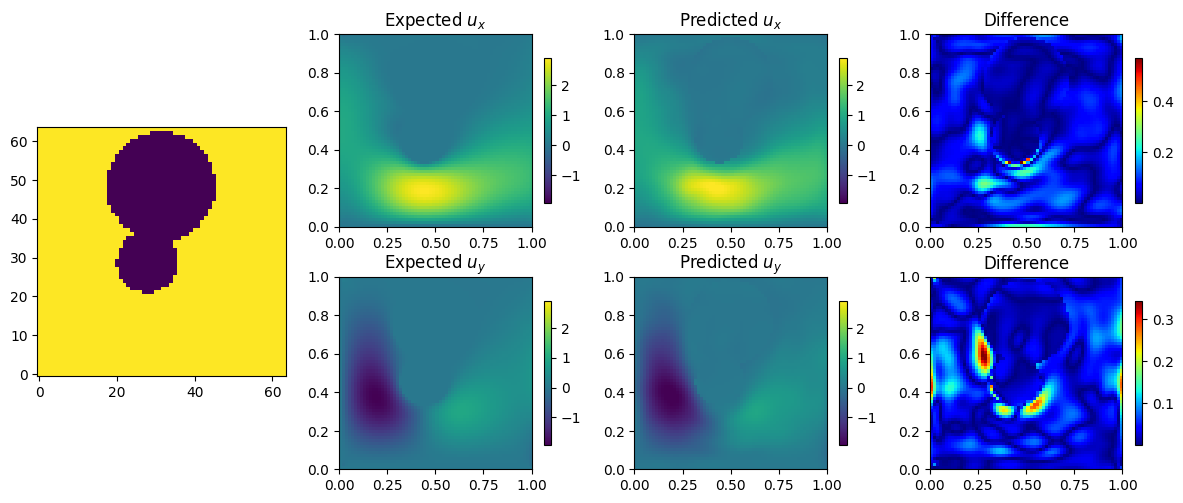

In [30]:
plot_idx = 353

sol_min = torch.min(test_out[plot_idx])
sol_max = torch.max(test_out[plot_idx])

# Plot 
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 4)

test_in = test_in.cpu()
# First column: just plot the input
ax_big = fig.add_subplot(gs[:, 0]) 
ax_big.imshow(test_in[plot_idx, :, :, 0], origin='lower')
axarr[0].title.set_text(r"Example domain")


# Remaining subplots (2 rows x 3 columns)
plot_data = [test_out[plot_idx], 
             model_output[plot_idx], 
             torch.abs(test_out[plot_idx] - model_output[plot_idx])]
title = [[r"Expected $u_x$", r"Predicted $u_x$", r"Difference"], 
         [r"Expected $u_y$", r"Predicted $u_y$", r"Difference"]]
for r in range(2):
    for c in range(1, 4):
        ax = fig.add_subplot(gs[r, c])
        if c < 3:
            img = ax.imshow(plot_data[c-1][:, :, r], extent=[0,1,0,1],
                            vmin=sol_min, vmax=sol_max, origin='lower')
        else:
            img = ax.imshow(plot_data[c-1][:, :, r], extent=[0,1,0,1], cmap='jet', origin='lower')
        plt.colorbar(img, ax=ax, shrink=0.75)
        ax.set_title(title[r][c-1])

plt.tight_layout()